In [91]:
import pymc_marketing as pmc
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm 
from scipy.stats import beta, gamma, halfnorm, norm
import seaborn as sns

In [49]:
from pymc_marketing.mmm.components.adstock import GeometricAdstock
from pymc_marketing.mmm.components.saturation import LogisticSaturation
from pymc_marketing.mmm import MMM

In [42]:
dummy_model = MMM(
    date_column="",
    channel_columns=[""],
    adstock= GeometricAdstock(l_max=4),
    saturation= LogisticSaturation(),
)
dummy_model.default_model_config

{'intercept': Prior("Normal", mu=0, sigma=2),
 'likelihood': Prior("Normal", sigma=Prior("HalfNormal", sigma=2)),
 'gamma_control': Prior("Normal", mu=0, sigma=2, dims="control"),
 'gamma_fourier': Prior("Laplace", mu=0, b=1, dims="fourier_mode"),
 'adstock_alpha': Prior("Beta", alpha=1, beta=3, dims="channel"),
 'saturation_lam': Prior("Gamma", alpha=3, beta=1, dims="channel"),
 'saturation_beta': Prior("HalfNormal", sigma=2, dims="channel")}

1. **intercept** – The baseline level of sales or target variable in the absence of any marketing spend or other variables. It sets the starting point for the model.
2. **likelihood** – When you increase the focus on the likelihood, the model relies more heavily on the observed data and less on the priors. This means the model will be more data-driven, allowing the observed outcomes to have a stronger influence on the parameter estimates
3. **gamma control** – Control variables that account for external factors, such as macroeconomic conditions, holidays, or other non-marketing variables that might influence sales.
4. **gamma fourier** – Fourier terms used to model seasonality in the data, capturing recurring patterns or cycles in sales.
5. **adstock alpha** – Controls the adstock effect, determining how much the impact of marketing spend decays over time.
6. **saturation lamda** – Defines the steepness of the saturation curve, determining how quickly diminishing returns set in as marketing spend increases.
7. **saturation beta** – The marketing spend coefficient, which measures the direct effect of marketing spend on the target variable (e.g. sales).

1. **Normal**: For parameters where we expect values to cluster around a mean.
2. **Half-Normal**: For parameters where we want to enforce positivity.
3. **Beta**: For parameters which are constrained between 0 and 1.
4. **Gamma**: For parameters that are positive and skewed.

__Adstock alpha__
Adstock reflects the idea that the influence of a marketing activity is delayed and builds up over time. The ** adstock alpha (the decay rate)** controls how quickly the effect diminishes over time, determining how long the impact of the marketing activity continues to influence sales.

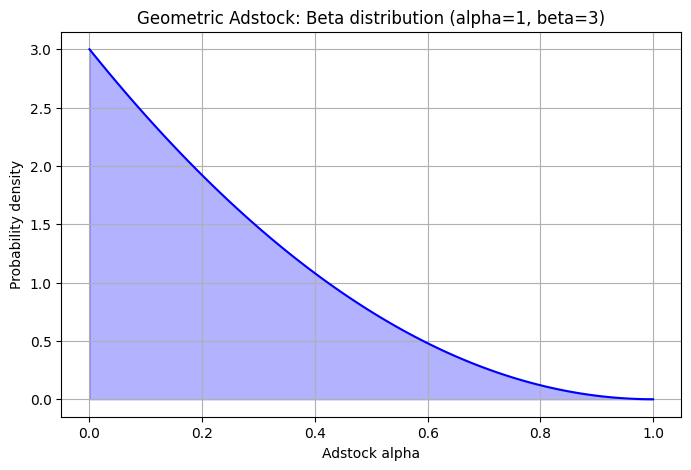

In [62]:
alpha = 1
beta_param = 3

x1 = np.linspace(0, 1, 100)
y1 = beta.pdf(x1, alpha, beta_param)

plt.figure(figsize=(8, 5))
plt.plot(x1, y1, color='blue')
plt.fill_between(x1, y1, color='blue', alpha=0.3)
plt.title('Geometric Adstock: Beta distribution (alpha=1, beta=3)')
plt.xlabel('Adstock alpha')
plt.ylabel('Probability density')
plt.grid(True)
plt.show()

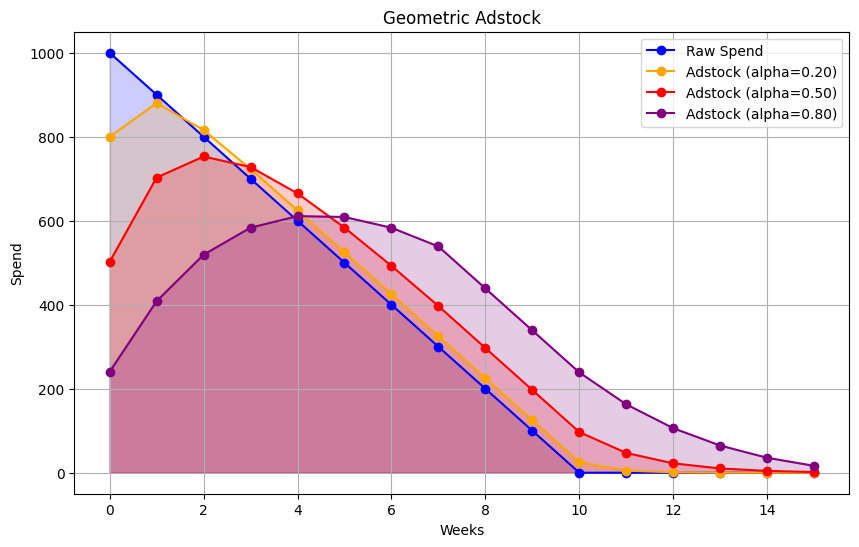

In [75]:
#To build further intuition, we can visualise the effect of different adstock alpha values:
from pymc_marketing.mmm.transformers import geometric_adstock

raw_spend = np.array([1000, 900, 800, 700, 600, 500, 400, 300, 200, 100, 0, 0, 0, 0, 0, 0])

adstock_spend_1 = geometric_adstock(x=raw_spend, alpha=0.20, l_max=8, normalize=True).eval().flatten()
adstock_spend_2 = geometric_adstock(x=raw_spend, alpha=0.50, l_max=8, normalize=True).eval().flatten()
adstock_spend_3 = geometric_adstock(x=raw_spend, alpha=0.80, l_max=8, normalize=True).eval().flatten()

plt.figure(figsize=(10, 6))

plt.plot(raw_spend, marker='o', label='Raw Spend', color='blue')
plt.fill_between(range(len(raw_spend)), 0, raw_spend, color='blue', alpha=0.2)

plt.plot(adstock_spend_1, marker='o', label='Adstock (alpha=0.20)', color='orange')
plt.fill_between(range(len(adstock_spend_1)), 0, adstock_spend_1, color='orange', alpha=0.2)

plt.plot(adstock_spend_2, marker='o', label='Adstock (alpha=0.50)', color='red')
plt.fill_between(range(len(adstock_spend_2)), 0, adstock_spend_2, color='red', alpha=0.2)

plt.plot(adstock_spend_3, marker='o', label='Adstock (alpha=0.80)', color='purple')
plt.fill_between(range(len(adstock_spend_3)), 0, adstock_spend_3, color='purple', alpha=0.2)

plt.xlabel('Weeks')
plt.ylabel('Spend')
plt.title('Geometric Adstock')
plt.legend()
plt.grid(True)
plt.show()

Low values of alpha have little impact and are suitable for channels which have a direct response e.g. paid social performance ads with a direct call to action aimed at prospects who have already visited your website.
Higher values of alpha have a stronger impact and are suitable for channels which have a longer term effect e.g. brand building videos with no direct call to action aimed at a broad range of prospects.

**Saturation lamda**

As we increase marketing spend, it’s incremental impact of sales slowly starts to reduce – This is known as saturation. Saturation lamda controls the steepness of the saturation curve, determining how quickly diminishing returns set in.
A gamma distribution is used as a prior for saturation lambda.

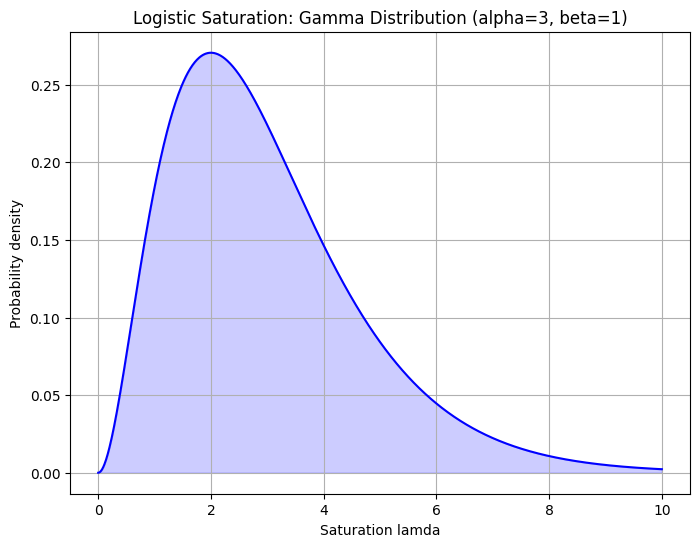

In [79]:
alpha = 3
beta = 1

x2 = np.linspace(0, 10, 1000)
y2 = gamma.pdf(x2, alpha, scale=1/beta)

plt.figure(figsize=(8, 6))
plt.plot(x2, y2, 'b-')
plt.fill_between(x2, y2, alpha=0.2, color='blue')
plt.title('Logistic Saturation: Gamma Distribution (alpha=3, beta=1)')
plt.xlabel('Saturation lamda')
plt.ylabel('Probability density')
plt.grid(True)
plt.show()

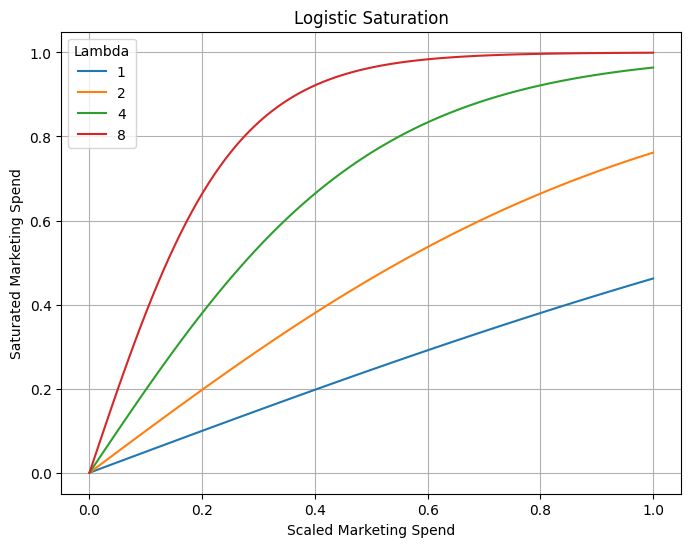

In [86]:
from pymc_marketing.mmm.transformers import logistic_saturation

scaled_spend = np.linspace(start=0.0, stop=1.0, num=100)

saturated_spend_1 = logistic_saturation(x=scaled_spend, lam=1).eval()
saturated_spend_2 = logistic_saturation(x=scaled_spend, lam=2).eval()
saturated_spend_4 = logistic_saturation(x=scaled_spend, lam=4).eval()
saturated_spend_8 = logistic_saturation(x=scaled_spend, lam=8).eval()

plt.figure(figsize=(8, 6))
sns.lineplot(x=scaled_spend, y=saturated_spend_1, label="1")
sns.lineplot(x=scaled_spend, y=saturated_spend_2, label="2")
sns.lineplot(x=scaled_spend, y=saturated_spend_4, label="4")
sns.lineplot(x=scaled_spend, y=saturated_spend_8, label="8")

plt.title('Logistic Saturation')
plt.xlabel('Scaled Marketing Spend')
plt.ylabel('Saturated Marketing Spend')
plt.legend(title='Lambda')
plt.grid(True)
plt.show()

**Saturation beta**
Saturation beta corresponds to the marketing channel coefficient, measuring the impact of marketing spend.

The half-normal prior is used as it enforces positivity which is a very reasonable assumption e.g. marketing shouldn’t have a negative effect. When sigma is set as 2, it tends towards low values. This helps regularize the coefficients, pulling them towards lower values unless there is strong evidence in the data that a particular channel has a significant impact.

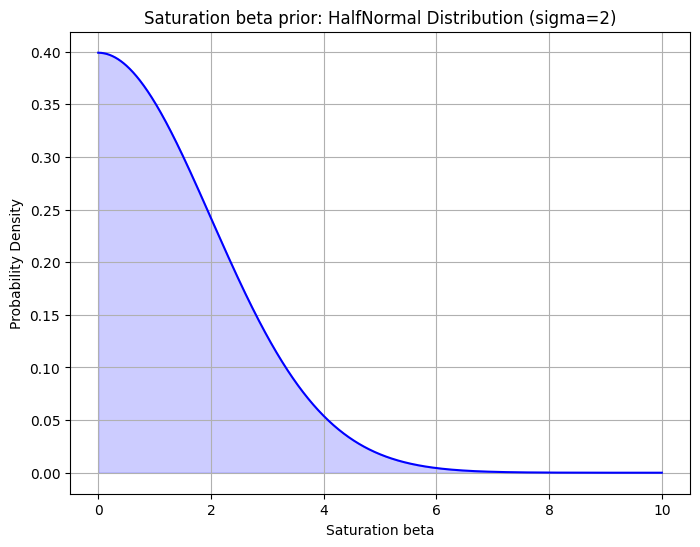

In [90]:
sigma = 2

x3 = np.linspace(0, 10, 1000)
y3 = halfnorm.pdf(x3, scale=sigma)

plt.figure(figsize=(8, 6))
plt.plot(x3, y3, 'b-')
plt.fill_between(x3, y3, alpha=0.2, color='blue')
plt.title('Saturation beta prior: HalfNormal Distribution (sigma=2)')
plt.xlabel('Saturation beta')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

Why the Half-Normal is Used:Marketing Principle: It enforces the crucial domain knowledge that advertising should not have a negative effect on sales ($\beta_i \ge 0$).Regularization/Shrinkage: By peaking at 0, the prior expresses a strong initial belief that most channels are ineffective or only minimally effective. This acts as a powerful shrinkage mechanism (like a Bayesian LASSO or Ridge penalty), pushing the estimates of weak channels close to zero.Bias is Intentional: This "bias towards zero" is intentional. It is a regularization bias designed to prevent the model from overfitting by assigning small, noisy effects to ineffective channels.3 Without strong evidence from the data, the coefficient stays near zero

**Gamma control**
The gamma control parameter is the coefficient for the control variables that account for external factors, such as macroeconomic conditions, holidays, or other non-marketing variables.

A normal distribution is used which allows for both positive and negative effects:

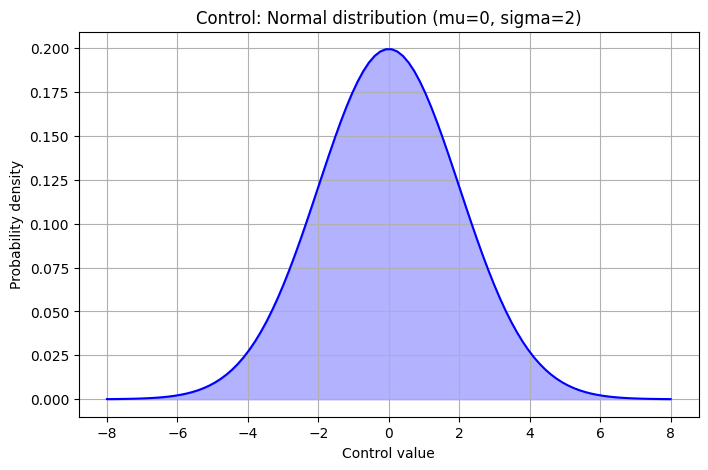

In [92]:
mu = 0
sigma = 2

x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
y = norm.pdf(x, mu, sigma)

plt.figure(figsize=(8, 5))
plt.plot(x, y, color='blue')
plt.fill_between(x, y, color='blue', alpha=0.3)
plt.title('Control: Normal distribution (mu=0, sigma=2)')
plt.xlabel('Control value')
plt.ylabel('Probability density')
plt.grid(True)
plt.show()

**Data Generator**

In [94]:
from sklearn.preprocessing import MaxAbsScaler

def data_generator(start_date, periods, channels, spend_scalar, adstock_alphas, saturation_lamdas, betas, freq="W"):
    '''
    Generates a synthetic dataset for a MMM with trend, seasonality, and channel-specific contributions.

    Args:
        start_date (str or pd.Timestamp): The start date for the generated time series data.
        periods (int): The number of time periods (e.g., days, weeks) to generate data for.
        channels (list of str): A list of channel names for which the model will generate spend and sales data.
        spend_scalar (list of float): Scalars that adjust the raw spend for each channel to a desired scale.
        adstock_alphas (list of float): The adstock decay factors for each channel, determining how much past spend influences the current period.
        saturation_lamdas (list of float): Lambda values for the logistic saturation function, controlling the saturation effect on each channel.
        betas (list of float): The coefficients for each channel, representing the contribution of each channel's impact on sales.

    Returns:
        pd.DataFrame: A DataFrame containing the generated time series data, including demand, sales, and channel-specific metrics.
    '''

    # 0. Create time dimension
    date_range = pd.date_range(start=start_date, periods=periods, freq=freq)
    df = pd.DataFrame({'date': date_range})

    # 1. Add trend component with some growth
    df["trend"]= (np.linspace(start=0.0, stop=20, num=periods) + 5) ** (1 / 8) - 1

    # 2. Add seasonal component with oscillation around 0
    df["seasonality"] = df["seasonality"] = 0.1 * np.sin(2 * np.pi * df.index / 52)

    # 3. Multiply trend and seasonality to create overall demand with noise
    df["demand"] = df["trend"] * (1 + df["seasonality"]) + np.random.normal(loc=0, scale=0.10, size=periods)
    df["demand"] = df["demand"] * 1000

    # 4. Create proxy for demand, which is able to follow demand but has some noise added
    df["demand_proxy"] = np.abs(df["demand"]* np.random.normal(loc=1, scale=0.10, size=periods))

    # 5. Initialize sales based on demand
    df["sales"] = df["demand"]

    # 6. Loop through each channel and add channel-specific contribution
    for i, channel in enumerate(channels):

        # Create raw channel spend, following demand with some random noise added
        df[f"{channel}_spend_raw"] = df["demand"] * spend_scalar[i]
        df[f"{channel}_spend_raw"] = np.abs(df[f"{channel}_spend_raw"] * np.random.normal(loc=1, scale=0.30, size=periods))

        # Scale channel spend
        channel_transformer = MaxAbsScaler().fit(df[f"{channel}_spend_raw"].values.reshape(-1, 1))
        df[f"{channel}_spend"] = channel_transformer .transform(df[f"{channel}_spend_raw"].values.reshape(-1, 1))

        # Apply adstock transformation
        df[f"{channel}_adstock"] = geometric_adstock(
            x=df[f"{channel}_spend"].to_numpy(),
            alpha=adstock_alphas[i],
            l_max=8, normalize=True
        ).eval().flatten()

        # Apply saturation transformation
        df[f"{channel}_saturated"] = logistic_saturation(
            x=df[f"{channel}_adstock"].to_numpy(),
            lam=saturation_lamdas[i]
        ).eval()

        # Calculate contribution to sales
        df[f"{channel}_sales"] = df[f"{channel}_saturated"] * betas[i]

        # Add the channel-specific contribution to sales
        df["sales"] += df[f"{channel}_sales"]

    return df

In [96]:
np.random.seed(10)

# Set parameters for data generator
start_date = "2021-01-01"
periods = 52 * 3
channels = ["tv", "social", "search"]
adstock_alphas = [0.50, 0.25, 0.05]
saturation_lamdas = [1.5, 2.5, 3.5]
betas = [350, 150, 50]
spend_scalars = [10, 15, 20]

In [99]:
import pandas as pd

In [101]:
df = data_generator(start_date, periods, channels, spend_scalars, adstock_alphas, saturation_lamdas, betas)
df

,date,trend,seasonality,demand,demand_proxy,sales,tv_spend_raw,tv_spend,tv_adstock,tv_saturated,...,social_spend_raw,social_spend,social_adstock,social_saturated,social_sales,search_spend_raw,search_spend,search_adstock,search_saturated,search_sales
0,2021-01-03,0.222845,0.000000,209.857836,245.961503,299.274470,1904.106625,0.203611,0.102205,0.076504,...,3341.303296,0.277135,0.207854,0.254125,38.118750,5185.585710,0.322784,0.306645,0.490432,24.521607
1,2021-01-10,0.226745,0.012054,200.169593,203.160572,327.737656,2432.607975,0.260125,0.181675,0.135419,...,4788.974873,0.397208,0.349874,0.411439,61.715841,3484.211968,0.216880,0.221368,0.369112,18.455588
2,2021-01-17,0.230561,0.023932,257.431865,269.523234,417.629953,3634.968958,0.388696,0.285947,0.211232,...,4472.023211,0.370919,0.365662,0.427699,64.154872,4402.989898,0.274071,0.271436,0.442240,22.112006
3,2021-01-24,0.234296,0.035460,354.407406,342.381579,534.520263,4580.630725,0.489818,0.388843,0.283636,...,3589.514859,0.297722,0.314710,0.374277,56.141570,5001.201374,0.311307,0.309314,0.493970,24.698525
4,2021-01-31,0.237953,0.046472,133.365296,123.964231,248.147975,891.174793,0.095295,0.242256,0.179719,...,1745.465892,0.144773,0.187259,0.229890,34.483496,3247.308755,0.202134,0.207493,0.347952,17.397609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,2023-11-26,0.491455,-0.056806,325.515140,400.955131,540.185748,2967.354673,0.317306,0.368256,0.269377,...,5766.423972,0.478279,0.504775,0.558719,83.807789,8565.858911,0.533195,0.532683,0.731616,36.580786
152,2023-12-03,0.492435,-0.046472,531.082170,549.808815,830.832023,7289.079718,0.779439,0.574492,0.406048,...,10601.189101,0.879285,0.785664,0.753965,113.094719,13325.921798,0.829492,0.814651,0.890770,44.538479
153,2023-12-10,0.493411,-0.035460,441.459072,387.905661,681.548608,2003.503560,0.214239,0.393503,0.286847,...,7438.242300,0.616943,0.659121,0.677187,101.578113,8990.645863,0.559636,0.572387,0.762298,38.114877
154,2023-12-17,0.494382,-0.023932,493.493848,473.490698,728.135852,4840.922618,0.517651,0.456086,0.329320,...,10066.240386,0.834915,0.790970,0.756813,113.521892,653.450176,0.040675,0.067261,0.117165,5.858270


In [109]:
test = geometric_adstock(
            x=df['tv_spend'].to_numpy(),
            alpha=0.5,
            l_max=8, normalize=True
        )

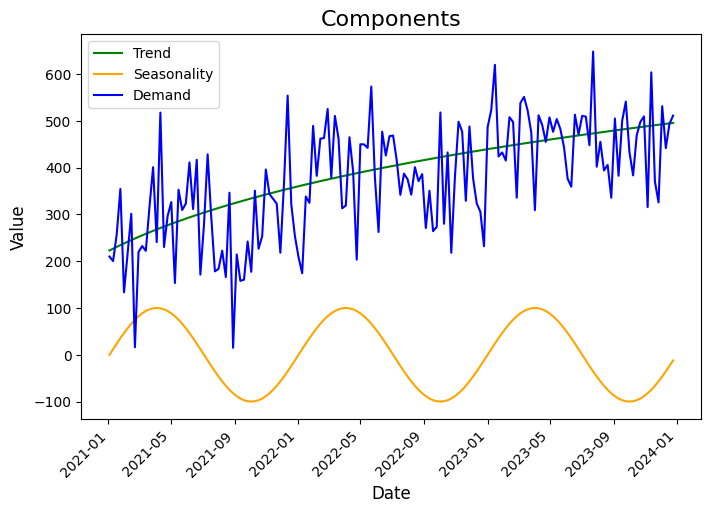

In [123]:
plt.figure(figsize=(8, 5))

sns.lineplot(x=df['date'], y=df['trend']*1000, label="Trend", color="green")
sns.lineplot(x=df['date'], y=df['seasonality']*1000, label="Seasonality", color="orange")
sns.lineplot(x=df['date'], y=df['demand'], label="Demand", color="blue")

plt.title('Components', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

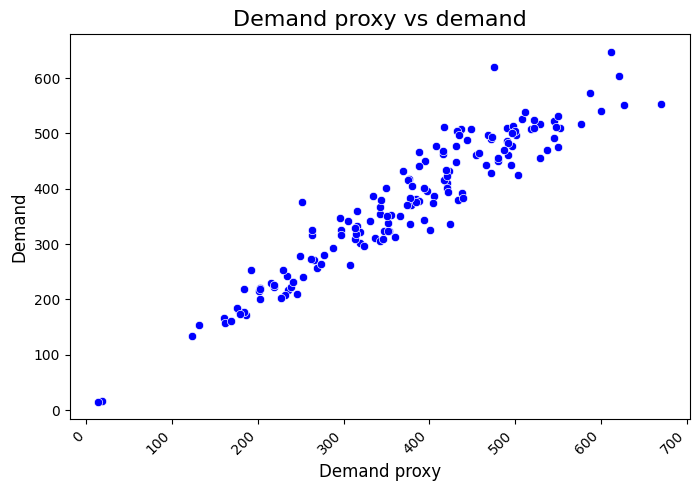

In [124]:
plt.figure(figsize=(8, 5))

sns.scatterplot(x=df['demand_proxy'], y=df['demand'], color="blue")

plt.title('Demand proxy vs demand', fontsize=16)
plt.xlabel('Demand proxy', fontsize=12)
plt.ylabel('Demand', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

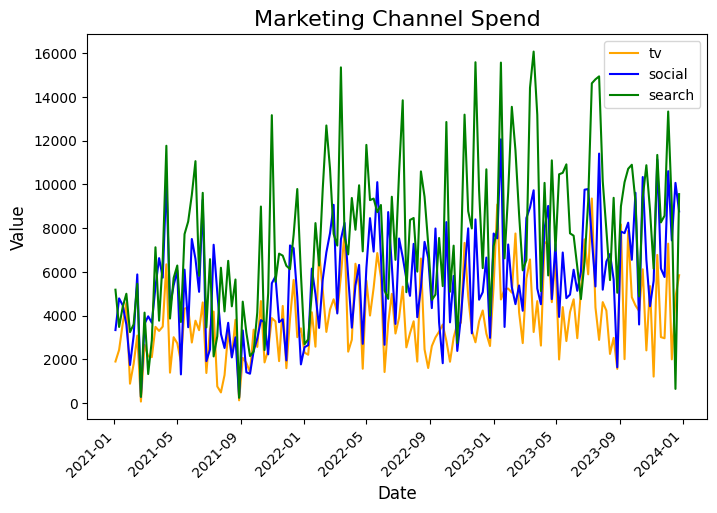

In [125]:
plt.figure(figsize=(8, 5))

sns.lineplot(x=df['date'], y=df['tv_spend_raw'], label=channels[0], color="orange")
sns.lineplot(x=df['date'], y=df['social_spend_raw'], label=channels[1], color="blue")
sns.lineplot(x=df['date'], y=df['search_spend_raw'], label=channels[2], color="green")
plt.title('Marketing Channel Spend', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

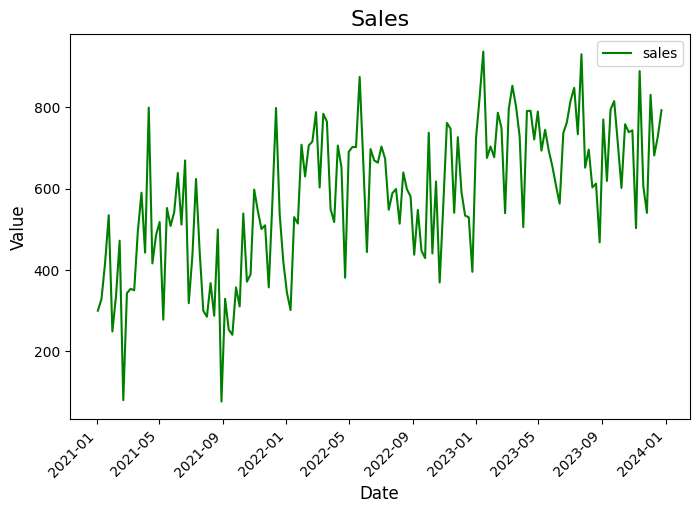

In [126]:
plt.figure(figsize=(8, 5))

sns.lineplot(x=df['date'], y=df['sales'], label="sales", color="green")

plt.title('Sales', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

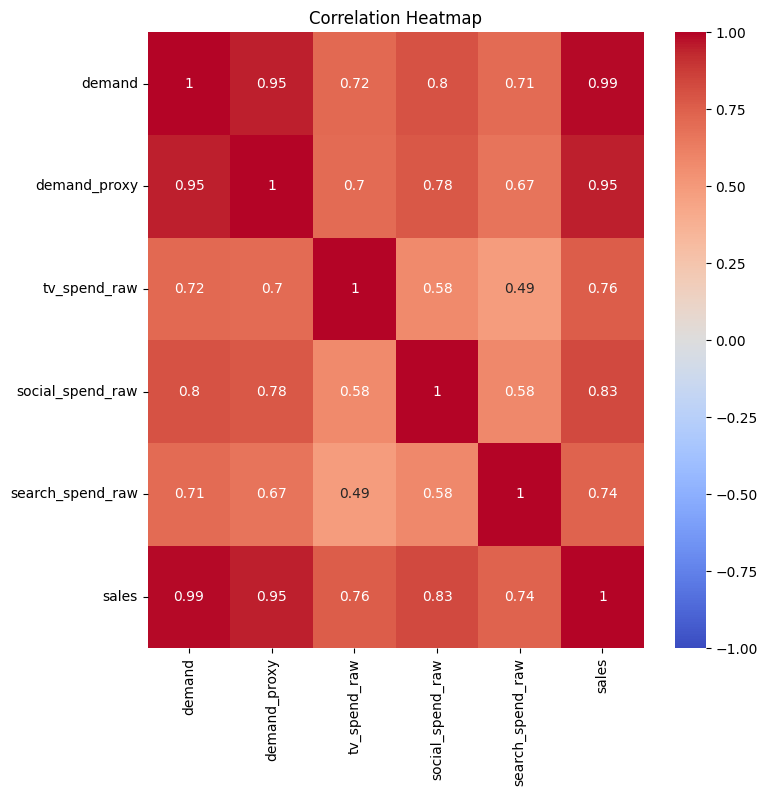

In [127]:
plt.figure(figsize=(8, 8))
sns.heatmap(df[["demand", "demand_proxy", "tv_spend_raw", "social_spend_raw", "search_spend_raw", "sales"]].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

**Training the Model**

In [138]:
# set date column
date_col = "date"

# set outcome column
y_col = "sales"

# set marketing variables
channel_cols = ["tv_spend_raw",
                "social_spend_raw",
                "search_spend_raw"]

# set control variables
control_cols = ["demand_proxy"]


# split data into features and target
X = df[[date_col] + channel_cols + control_cols]
y = df[y_col]
print(X, y)

          date  tv_spend_raw  social_spend_raw  search_spend_raw  demand_proxy
0   2021-01-03   1904.106625       3341.303296       5185.585710    245.961503
1   2021-01-10   2432.607975       4788.974873       3484.211968    203.160572
2   2021-01-17   3634.968958       4472.023211       4402.989898    269.523234
3   2021-01-24   4580.630725       3589.514859       5001.201374    342.381579
4   2021-01-31    891.174793       1745.465892       3247.308755    123.964231
..         ...           ...               ...               ...           ...
151 2023-11-26   2967.354673       5766.423972       8565.858911    400.955131
152 2023-12-03   7289.079718      10601.189101      13325.921798    549.808815
153 2023-12-10   2003.503560       7438.242300       8990.645863    387.905661
154 2023-12-17   4840.922618      10066.240386        653.450176    473.490698
155 2023-12-24   5845.632169       8764.130108       9552.877856    547.526939

[156 rows x 5 columns] 0      299.274470
1      327

In [143]:
# create train and test indices

test_len = 8
train_idx = slice(0, len(df) - test_len)
out_of_time_idx = slice(len(df) - test_len, len(df))

In [145]:
mmm_default = MMM(
    adstock=GeometricAdstock(l_max=8),
    saturation=LogisticSaturation(),
    date_column=date_col,
    channel_columns=channel_cols,
    control_columns=control_cols,
)

mmm_default.default_model_config

{'intercept': Prior("Normal", mu=0, sigma=2),
 'likelihood': Prior("Normal", sigma=Prior("HalfNormal", sigma=2)),
 'gamma_control': Prior("Normal", mu=0, sigma=2, dims="control"),
 'gamma_fourier': Prior("Laplace", mu=0, b=1, dims="fourier_mode"),
 'adstock_alpha': Prior("Beta", alpha=1, beta=3, dims="channel"),
 'saturation_lam': Prior("Gamma", alpha=3, beta=1, dims="channel"),
 'saturation_beta': Prior("HalfNormal", sigma=2, dims="channel")}

In [ ]:
fit_kwargs = {
    "tune": 1_000,
    "chains": 4,
    "draws": 1_000,
    "target_accept": 0.9,
}

mmm_default.fit(X[train_idx], y[train_idx], **fit_kwargs)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, adstock_alpha, saturation_lam, saturation_beta, gamma_control, y_sigma]


C:\Users\sahil\miniconda3\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [147]:
# These arguments are typically passed to the sampling function (like pm.sample)
fit_kwargs = {
    # 1. tune (Burn-in Period)
    # The number of initial samples discarded for the MCMC process.
    # Used by the NUTS sampler to tune its internal parameters (step size, mass matrix).
    # These samples are thrown away as they are not representative of the true posterior.
    "tune": 1_000, 

    # 2. chains
    # The number of independent Markov Chain Monte Carlo (MCMC) simulations to run.
    # Crucial for assessing convergence and ensuring the posterior space is thoroughly explored.
    "chains": 4,   

    # 3. draws (Posterior Samples)
    # The number of useful posterior samples saved AFTER the tuning period is complete.
    # These are used for all statistical inference (mean, credible intervals, etc.).
    # Total saved samples = chains * draws (4 * 1000 = 4,000 in this case).
    "draws": 1_000,

    # 4. target_accept
    # The desired average acceptance probability for the NUTS sampler.
    # Controls the trade-off between sampling quality (higher value = better) and speed.
    # Increasing this (e.g., from 0.8 to 0.9) helps resolve divergent transitions.
    "target_accept": 0.9, 
}